Useful command to copy files from google drive to colab's local storage. Then, for example, you could copy them to your drive using the same command but different args. This is what's needed to do a deep copy of shared folders.

In [ ]:
# !rsync -ah --progress -r drive/MyDrive/Universita/MLDL/BiseNetv1/checkpoint_101_adversarial_both_augmentations/ checkpoint_101_adversarial_both_augmentations

# Setup

## Mount Drive

Mount Google Drive. This will create a new folder, called `My Drive` under `/content/drive/`. It is a FUSE-like filesystem mounted over the network, so the average IO performance is quite slow.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Move into the `BiseNetv1` directory, so that we are in the correct directory for python imports

In [4]:
%cd /content/drive/MyDrive/Universita/MLDL/BiseNetv1/

/content/drive/MyDrive/Universita/MLDL/BiseNetv1


In [5]:
%pwd

'/content/drive/MyDrive/Universita/MLDL/BiseNetv1'

Use autoreload extension so that when we change an imported module, it will get autoreloaded.

In [6]:
%load_ext autoreload
%autoreload 2

## Download

Download `CamVid` and `IDDA` datasets from a Google Cloud Storage bucket. Previously we downloaded them from Google Drive but there is (rightly so) a quite small download quota.

Files are downloaded to the local disk which has much faster IO than the mounted drive.

In [7]:
%%time
%cd /content
%pwd
!gsutil cp gs://recsys-2021-bucket/CamVid.zip /content/CamVid.zip
!gsutil cp gs://recsys-2021-bucket/IDDA.zip /content/IDDA.zip
!unzip -q CamVid.zip
!unzip -q IDDA.zip
!cp /content/drive/MyDrive/Universita/MLDL/classes_info.json /content/IDDA/classes_info.json
%cd /content/drive/MyDrive/Universita/MLDL/BiseNetv1/

/content
Copying gs://recsys-2021-bucket/CamVid.zip...
| [1 files][579.3 MiB/579.3 MiB]   54.1 MiB/s                                   
Operation completed over 1 objects/579.3 MiB.                                    
Copying gs://recsys-2021-bucket/IDDA.zip...
/ [1 files][  4.9 GiB/  4.9 GiB]   38.6 MiB/s                                   
Operation completed over 1 objects/4.9 GiB.                                      
/content/drive/MyDrive/Universita/MLDL/BiseNetv1
CPU times: user 1.49 s, sys: 309 ms, total: 1.8 s
Wall time: 3min 7s


# Validation

## Check GPU RAM

In [9]:
!nvidia-smi

Sat Jun 19 14:05:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    53W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup

In [10]:
import torch

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()
%config InlineBackend.figure_format = 'retina'
from utils import reverse_one_hot, colour_code_segmentation
from torchvision import transforms as T

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
unnormalize = T.Normalize((-mean/std).tolist(), (1.0 / std).tolist())

In [11]:
!pip3 install tensorboardX

     |████████████████████████████████| 122kB 6.6MB/s 


In [12]:
from dataclasses import dataclass
@dataclass
class MyArgs:
  num_classes: int
  use_gpu: bool
  loss: str
from train import val

## Load generator checkpoint and datasets

Create BiSeNet and put it on the GPU.
Load the weights of the network we want to train.
Put the generator in `eval` mode, this is needed for e.g. batch normalization layers.

In [13]:
from model.build_BiSeNet import BiSeNet
NUM_CLASSES = 12
CONTEXT_PATH = 'resnet101'
generator = BiSeNet(NUM_CLASSES, CONTEXT_PATH).cuda()

In [14]:
!pwd

/content/drive/My Drive/Universita/MLDL/BiseNetv1


In [16]:
generator.load_state_dict(torch.load('/content/drive/MyDrive/Universita/MLDL/BiseNetv1/checkpointBeta09/0.09_50_Generator.pth'))
generator.eval()
None

Now load both source and target dataset, respectively `IDDA` and `CamVid`.
Both datasets are loaded in `validation` mode, but the data which is loaded is actually the __training__ data, so be careful.

In [17]:
from torch.utils.data import DataLoader

from dataset.IDDA import IDDA
from dataset.CamVid import CamVid


CROP_HEIGHT = 720
CROP_WIDTH = 960

NUM_WORKERS = 0

CAMVID_PATH = ['/content/CamVid/train/', '/content/CamVid/val/']
CAMVID_TEST_PATH = ['/content/CamVid/test/']
CAMVID_LABEL_PATH = ['/content/CamVid/train_labels/', '/content/CamVid/val_labels/']
CAMVID_TEST_LABEL_PATH = ['/content/CamVid/test_labels/']
CSV_CAMVID_PATH = '/content/CamVid/class_dict.csv'

IDDA_PATH = '/content/IDDA/rgb/'
IDDA_LABEL_PATH = '/content/IDDA/labels'
JSON_IDDA_PATH = '/content/IDDA/classes_info.json'

BATCH_SIZE_CAMVID = 2
BATCH_SIZE_IDDA = 2

LOSS = 'dice'

source_dataset = IDDA(
    image_path=IDDA_PATH,
    label_path=IDDA_LABEL_PATH,
    classes_info_path=JSON_IDDA_PATH,
    scale=(CROP_HEIGHT, CROP_WIDTH),
    loss=LOSS,
    mode='val'
)
source_dataloader = DataLoader(
  source_dataset,
  batch_size=1,
  shuffle=True,
  num_workers=NUM_WORKERS,
  drop_last=True,
  pin_memory=True
)
target_dataset = CamVid(
  image_path=CAMVID_PATH,
  label_path= CAMVID_LABEL_PATH,csv_path= CSV_CAMVID_PATH,
  scale=(CROP_HEIGHT, CROP_WIDTH),
  loss=LOSS,
  mode='val'
)
target_dataloader = DataLoader(
  target_dataset,
  batch_size=1,
  shuffle=True,
  num_workers=NUM_WORKERS,
  drop_last=True,
  pin_memory=True
)
source_dataloader_iter = iter(source_dataloader)
target_dataloader_iter = iter(target_dataloader)

So this is the performance on the **training** target dataset.

In [18]:
%%time
# val(MyArgs(NUM_CLASSES, True, 'dice'), generator, target_dataloader_iter)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


Now we load `CamVid` test data in `validation` mode. This is what we actually use to calculate validation performance.

In [37]:
%%time
target_dataset_test = CamVid(
  image_path=CAMVID_TEST_PATH,
  label_path= CAMVID_TEST_LABEL_PATH,csv_path= CSV_CAMVID_PATH,
  scale=(CROP_HEIGHT, CROP_WIDTH),
  loss=LOSS,
  mode='val'
)
target_dataloader_test = DataLoader(
  target_dataset_test,
  batch_size=1,
  shuffle=True,
  num_workers=NUM_WORKERS,
  drop_last=True,
  pin_memory=True
)
target_dataloader_test_iter = iter(target_dataloader_test)
val(MyArgs(NUM_CLASSES, True, 'dice'), generator, target_dataloader_test_iter, CSV_CAMVID_PATH)

start val!!
precision per pixel for test: 0.682
mIoU for validation: 0.291
mIoU for each class:
Bicyclist:0.03418758630788285,
Building:0.5862791034766172,
Car:0.48289298608172265,
Column_Pole:0.016455359104638224,
Fence:0.0042329819011427275,
Pedestrian:0.0008823281712315742,
Road:0.6939546757620721,
Sidewalk:0.31233302858139866,
SignSymbol:6.124141924034915e-05,
Sky:0.6839484547236347,
Tree:0.38825005068853663,

CPU times: user 4min 35s, sys: 911 ms, total: 4min 36s
Wall time: 4min 28s


## Create validation curve

In [ ]:
results = []
for epoch in range(5, 51, 5):
  target_dataloader_test_iter = iter(target_dataloader_test)
  generator.load_state_dict(torch.load(f'/content/drive/MyDrive/Universita/MLDL/BiseNetv1/checkpoint_101_adversarial_both_augmentation_epoch_len_IDDA/{epoch}_Generator.pth'))
  generator.eval()
  validation_result = val(MyArgs(NUM_CLASSES, True, 'dice'), generator, target_dataloader_test_iter)
  print(epoch, validation_result)
  results.append((epoch, validation_result))
results

start val!
precision per pixel for test: 0.669
mIoU for validation: 0.293
5 (0.6686356439258465, 0.29301514409492424)
start val!
precision per pixel for test: 0.701
mIoU for validation: 0.331
10 (0.7006315569861707, 0.33090263495729305)
start val!
precision per pixel for test: 0.695
mIoU for validation: 0.347
15 (0.6953772874940389, 0.346956391683519)
start val!
precision per pixel for test: 0.678
mIoU for validation: 0.335
20 (0.6780706813304721, 0.33485004480142994)
start val!
precision per pixel for test: 0.670
mIoU for validation: 0.332
25 (0.6696029111528374, 0.3324233206554515)
start val!
precision per pixel for test: 0.663
mIoU for validation: 0.325
30 (0.6634729735435543, 0.3249984991515137)
start val!
precision per pixel for test: 0.661
mIoU for validation: 0.326
35 (0.6612371468168812, 0.32641483149985534)
start val!
precision per pixel for test: 0.635
mIoU for validation: 0.306
40 (0.6349022723434272, 0.3057748601213181)
start val!
precision per pixel for test: 0.611
mIoU fo

[(5, (0.6686356439258465, 0.29301514409492424)),
 (10, (0.7006315569861707, 0.33090263495729305)),
 (15, (0.6953772874940389, 0.346956391683519)),
 (20, (0.6780706813304721, 0.33485004480142994)),
 (25, (0.6696029111528374, 0.3324233206554515)),
 (30, (0.6634729735435543, 0.3249984991515137)),
 (35, (0.6612371468168812, 0.32641483149985534)),
 (40, (0.6349022723434272, 0.3057748601213181)),
 (45, (0.6106800575723256, 0.2883965959833228)),
 (50, (0.6106359779844223, 0.28546795898578126))]

In [ ]:
([x[0] for x in results], [x[1] for x in results])

([5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
 [(0.6686356439258465, 0.29301514409492424),
  (0.7006315569861707, 0.33090263495729305),
  (0.6953772874940389, 0.346956391683519),
  (0.6780706813304721, 0.33485004480142994),
  (0.6696029111528374, 0.3324233206554515),
  (0.6634729735435543, 0.3249984991515137),
  (0.6612371468168812, 0.32641483149985534),
  (0.6349022723434272, 0.3057748601213181),
  (0.6106800575723256, 0.2883965959833228),
  (0.6106359779844223, 0.28546795898578126)])

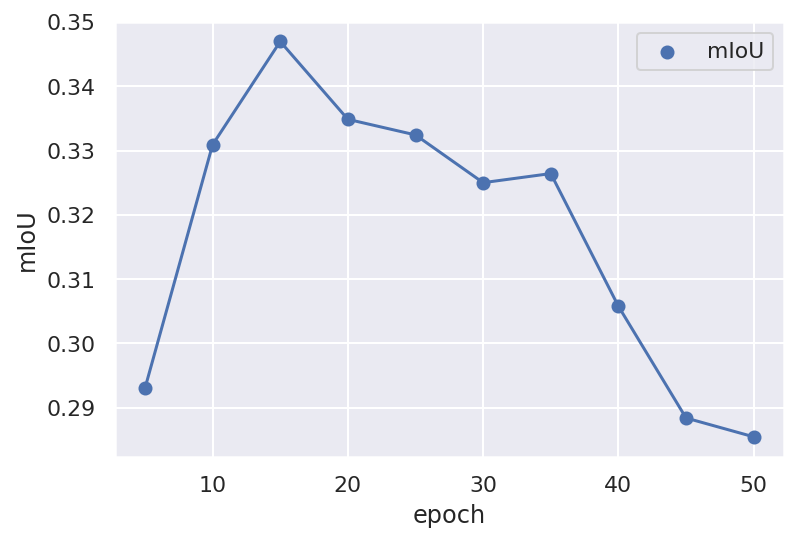

In [ ]:
plt.scatter([x[0] for x in results], [x[1][1] for x in results], label='mIoU')
plt.plot([x[0] for x in results], [x[1][1] for x in results])
# plt.scatter([x[0] for x in results], [x[1][0] for x in results])
# plt.plot([x[0] for x in results], [x[1][0] for x in results])
plt.xlabel('epoch')
plt.ylabel('mIoU')
plt.legend()

## Visually compare target and source predictions and their targets

torch.Size([2, 3, 1080, 1920]) torch.Size([2, 12, 1080, 1920]) torch.Size([2, 3, 720, 960]) torch.Size([2, 12, 720, 960])


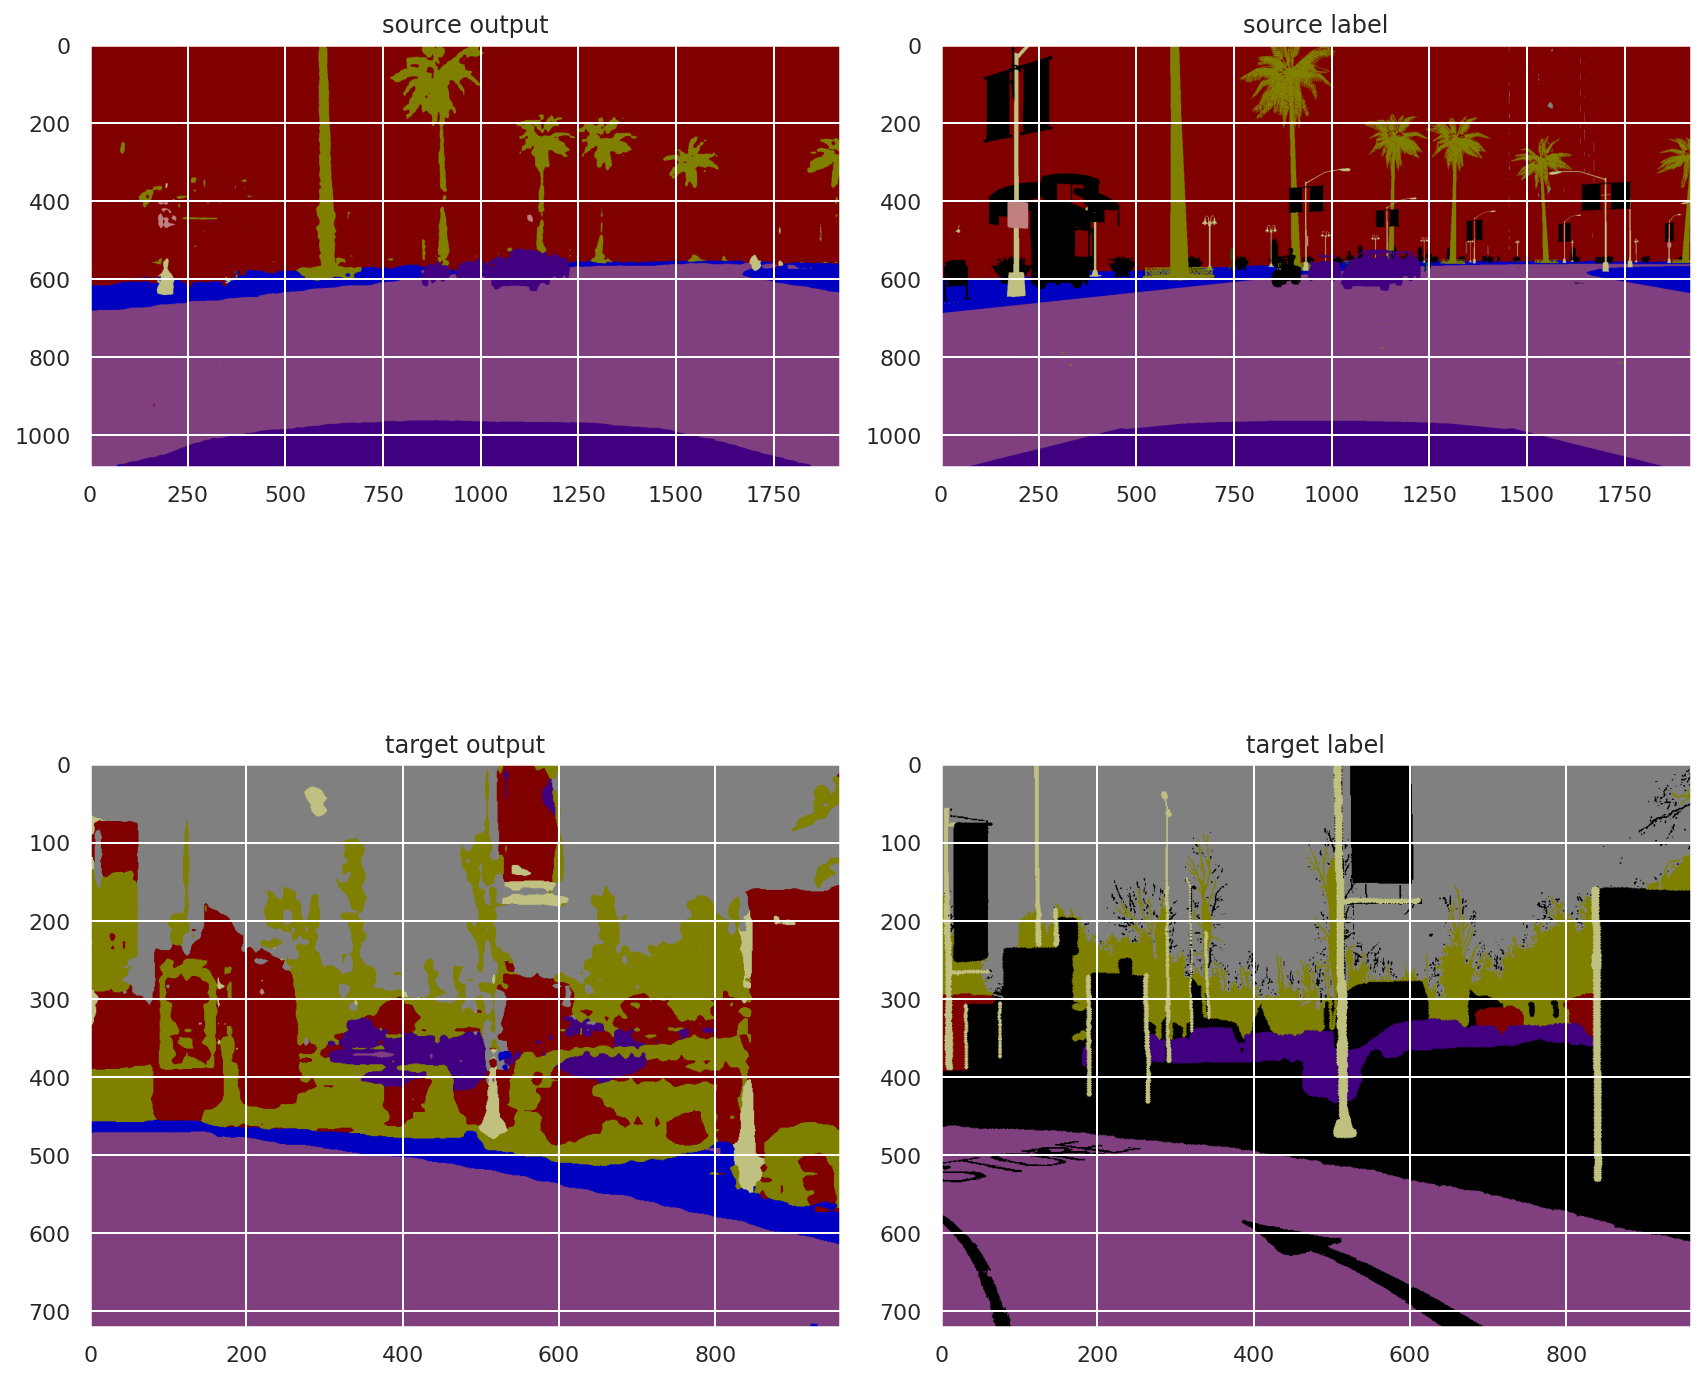

In [ ]:
I_s, Y_s = next(source_dataloader_iter)
I_t, Y_t = next(target_dataloader_iter)
print(I_s.shape, Y_s.shape, I_t.shape, Y_t.shape)
with torch.no_grad():
  P_s = generator(I_s.cuda())
P_s.shape
with torch.no_grad():
  P_t = generator(I_t.cuda())
P_t.shape
MINIBATCH_INDEX = 1
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
ax1.set_title("source output")
ax1.imshow(colour_code_segmentation(reverse_one_hot(P_s[MINIBATCH_INDEX, :, :, :]).cpu().numpy(), target_dataset.label_info))
ax2.set_title("source label")
ax2.imshow(colour_code_segmentation(reverse_one_hot(Y_s[MINIBATCH_INDEX, :, :, :]).cpu().numpy(), target_dataset.label_info))
ax3.set_title("target output")
ax3.imshow(colour_code_segmentation(reverse_one_hot(P_t[MINIBATCH_INDEX, :, :, :]).cpu().numpy(), target_dataset.label_info))
ax4.set_title("target label")
ax4.imshow(colour_code_segmentation(reverse_one_hot(Y_t[MINIBATCH_INDEX, :, :, :]).cpu().numpy(), target_dataset.label_info))
fig.tight_layout()

# Running


In [8]:
!python train_FDA_adversarial_09.py

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100% 44.7M/44.7M [00:00<00:00, 68.2MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100% 171M/171M [00:02<00:00, 81.1MB/s]
begin epoch 41
100% 234/234 [05:50<00:00,  1.50s/it]
epoch = 41/250000, loss_seg = 59.782, loss_adv = 68.643, loss_D = 387.035
begin epoch 42
100% 234/234 [05:43<00:00,  1.47s/it]
epoch = 42/250000, loss_seg = 55.187, loss_adv = 68.969, loss_D = 385.738
begin epoch 43
100% 234/234 [05:42<00:00,  1.46s/it]
epoch = 43/250000, loss_seg = 56.122, loss_adv = 68.853, loss_D = 386.171
begin epoch 44
100% 234/234 [05:41<00:00,  1.46s/it]
epoch = 44/250000, loss_seg = 56.045, loss_adv = 69.033, loss_D = 385.532
begin epoch 45
100% 234/234 [05:42<00:00,  1.46s/it]
epoch = 45/250000, loss_seg = 55.532, loss_adv = 68.926, loss_D = 385.995
saved:
./checkpoi

dwadawdawdwa
**OHHH** look at *this* $\frac{1}{2}$